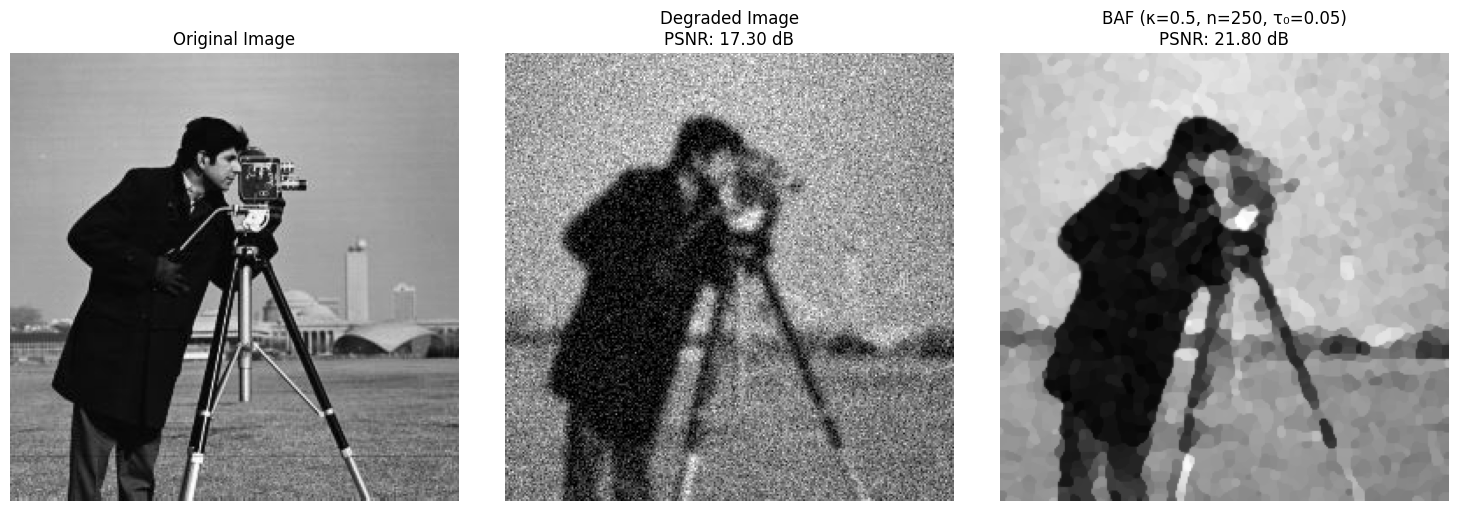

PSNR (Degraded): 17.30 dB
PSNR (Filtered): 21.80 dB


In [1]:
import numpy as np
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from PIL import Image
from skimage import metrics
import warnings
warnings.filterwarnings("ignore")  # Suppress interpolation warnings

# Function to compute gradient magnitude
def compute_gradient_magnitude(image, rho=0):
    if rho > 0:
        image = ndimage.gaussian_filter(image, sigma=rho)
    grad_x = ndimage.sobel(image, axis=1, mode='reflect')
    grad_y = ndimage.sobel(image, axis=0, mode='reflect')
    return np.sqrt(grad_x**2 + grad_y**2)

# Function to compute external force field (VFC approximation)
def compute_external_field(grad_mag):
    # Use normalized gradient of gradient magnitude as a proxy for VFC
    grad_x = ndimage.sobel(grad_mag, axis=1, mode='reflect')
    grad_y = ndimage.sobel(grad_mag, axis=0, mode='reflect')
    norm = np.sqrt(grad_x**2 + grad_y**2 + 1e-10)  # Avoid division by zero
    u_f = grad_x / norm
    v_f = grad_y / norm
    return u_f, v_f

# Function to perform advection
def advect(image, u, v):
    h, w = image.shape
    x = np.arange(w)
    y = np.arange(h)
    interp = RegularGridInterpolator((y, x), image, method='linear', bounds_error=False, fill_value=0)
    
    # Create meshgrid for coordinates
    X, Y = np.meshgrid(x, y)
    # New coordinates after advection
    new_x = X - u
    new_y = Y - v
    # Clip coordinates to image bounds
    new_x = np.clip(new_x, 0, w-1)
    new_y = np.clip(new_y, 0, h-1)
    # Interpolate
    coords = np.stack((new_y, new_x), axis=-1)
    return interp(coords)

# Biased Advection Filter (BAF)
def BAF(image, n, tau0, kappa, rho):
    result = image.copy()
    for _ in range(n):
        # Random angles for stochastic advection field
        theta = np.random.uniform(0, 2*np.pi, image.shape)
        u = np.cos(theta)
        v = np.sin(theta)
        # Compute gradient magnitude
        grad_mag = compute_gradient_magnitude(result, rho)
        # Compute external force field (VFC)
        u_f, v_f = compute_external_field(grad_mag)
        # Compute tau based on gradient
        tau = tau0 * (1 / (1 + (grad_mag / kappa)**2))
        # Combine stochastic and deterministic fields
        u_scaled = tau * (u + u_f)
        v_scaled = tau * (v + v_f)
        # Advect image
        result = advect(result, u_scaled, v_scaled)
    return result

# Load image
image_path = r"Input Image/original_cameraman.jpg"
try:
    image = np.array(Image.open(image_path).convert('L')).astype(np.float32) / 255.0  # Convert to grayscale and normalize
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    exit(1)

# Apply degradation model: Gaussian blur (rho0 = 2) + AWGN (sigma = 30/255)
rho0 = 2
sigma = 30 / 255.0
blurred_image = ndimage.gaussian_filter(image, sigma=rho0)
degraded_image = blurred_image + np.random.normal(0, sigma, image.shape)
degraded_image = np.clip(degraded_image, 0, 1)

# Parameters
n = 250
tau0 = 0.05
kappa = 0.5
rho = 0

# Apply BAF
filtered_image = BAF(degraded_image, n, tau0, kappa, rho)

# Calculate PSNR
psnr_degraded = metrics.peak_signal_noise_ratio(image, degraded_image, data_range=1.0)
psnr_filtered = metrics.peak_signal_noise_ratio(image, filtered_image, data_range=1.0)

# Display results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Degraded image
plt.subplot(1, 3, 2)
plt.imshow(degraded_image, cmap='gray')
plt.title(f'Degraded Image\nPSNR: {psnr_degraded:.2f} dB')
plt.axis('off')

# Filtered image
plt.subplot(1, 3, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title(f'BAF (κ={kappa}, n={n}, τ₀={tau0})\nPSNR: {psnr_filtered:.2f} dB')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print PSNR values
print(f"PSNR (Degraded): {psnr_degraded:.2f} dB")
print(f"PSNR (Filtered): {psnr_filtered:.2f} dB")